## Speech Emotion Recognition Project

This notebook contains the implementation of the above project found [here](https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/). The code provided in the original project is denoted by *DataFlair* at the beginning of the comment. Additions I have made are denoted by *NG*.

In [84]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [46]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file

def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [3]:
#DataFlair - Emotions in the RAVDESS dataset

emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

# Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [4]:
!pwd

/c/Users/njeri/Projects/speech_rec


In [5]:
#DataFlair - Load the data and extract features for each sound file

def load_data(test_size=0.2):
    X,y=[],[]
    for file in glob.glob("C:\\Users\\njeri\\Projects\\speech_rec\\data\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        X.append(feature)
        y.append(emotion)
    return train_test_split(np.array(X), y, test_size=test_size, random_state=9)

In [6]:
#DataFlair - Split the dataset

X_train, X_test, y_train, y_test = load_data(test_size=0.25)

In [7]:
#DataFlair - Get the shape of the training and testing datasets

print((X_train.shape[0], X_test.shape[0]))

(576, 192)


In [8]:
#DataFlair - Get the number of features extracted

print(f'Features extracted: {X_train.shape[1]}')

Features extracted: 180


In [78]:
#NG - Establish a baseline with Dummy Classifier

dummy_model = DummyClassifier(strategy='stratified', random_state=3)
dummy_model.fit(X_train, y_train)
dummy_model.predict(X_test)
print(f'Accuracy: {round(dummy_model.score(X_test, y_test), 2)*100}%')

Accuracy: 22.0%


In [87]:
#DataFlair - Initialize the Multi Layer Perceptron Classifier
#NG - added early stopping and validation fraction to provide validation data for loss comparison against training data

model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [88]:
%%time
#DataFlair - Train the model

model.fit(X_train, y_train)

Wall time: 1.05 s


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [89]:
#DataFlair - Predict for the test set

y_pred = model.predict(X_test)

In [90]:
#DataFlair - Calculate the accuracy of our model
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 62.50%


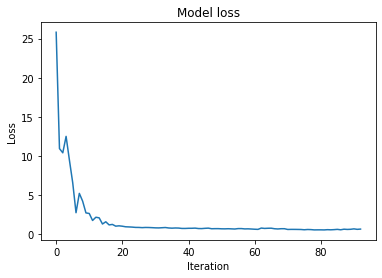

In [56]:
#NG - Plot the loss curve
plt.plot(model.loss_curve_)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('visualizations/model_loss.png')
plt.show()

In [15]:
#NG - Inspect other attributes to get a sense of model structure

print(f'Best loss: {round(model.best_loss_, 2)}')
print(f'Number of iterations: {model.n_iter_}')
print(f'Number of layers: {model.n_layers_}')
print(f'Output activation function: {model.out_activation_}')

Best loss: 0.54
Number of iterations: 93
Number of layers: 3
Output activation function: softmax


## Tune Model

The MLPClassifier had a higher accuracy score (62%) than the baseline classifier (22%). Let's try to improve this score by tuning the hyperparameters of the model. Implementation from here on is my own.

In [16]:
%%time
# Perform a grid search to identify best model parameters

estimator = MLPClassifier(max_iter=1000)

# Set parameters to search
parameters = {
    'hidden_layer_sizes': [(100,), (150, 100), (200, 150, 100)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam']
    }

# Perform grid search
grid_search = GridSearchCV(estimator, parameters, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", refit=True)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Wall time: 4min 50s


GridSearchCV(estimator=MLPClassifier(max_iter=1000), n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(100,), (150, 100),
                                                (200, 150, 100)],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='accuracy', verbose=1)

In [17]:
# Inspect best estimator

print(f'Best estimator: {grid_search.best_estimator_}')
print(f'Best parameters: {grid_search.best_params_}')

Best estimator: MLPClassifier(activation='logistic', hidden_layer_sizes=(150, 100),
              max_iter=1000)
Best parameters: {'activation': 'logistic', 'hidden_layer_sizes': (150, 100), 'solver': 'adam'}


In [18]:
# Predict and score on test data
y_pred = grid_search.predict(X_test)
accuracy_2 = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy_2*100))

Accuracy: 80.21%


### Change number of neurons in each hidden layer

The original DataFlair model used the default Rectified Linear Unit (relu) activation function, 1 hidden layer, and the adam solver. Through grid search, logistic activation and using 2 hidden neuron layers increased accuracy from 61% to 80%. Let's see if increasing the neurons in each layer yields a better result. 

In [19]:
%%time
estimator_2 = MLPClassifier(activation='logistic', solver='adam', max_iter=1000)
parameters_2 = {'hidden_layer_sizes': [(150, 100), (250, 150), (350, 250)]}
grid_search_2 = GridSearchCV(estimator_2, parameters_2, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", refit=True)
grid_search_2.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Wall time: 47.8 s


GridSearchCV(estimator=MLPClassifier(activation='logistic', max_iter=1000),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(150, 100), (250, 150),
                                                (350, 250)]},
             scoring='accuracy', verbose=1)

In [20]:
print(f'Best estimator: {grid_search_2.best_estimator_}')
print(f'Best parameters: {grid_search_2.best_params_}')

Best estimator: MLPClassifier(activation='logistic', hidden_layer_sizes=(250, 150),
              max_iter=1000)
Best parameters: {'hidden_layer_sizes': (250, 150)}


In [21]:
y_pred = grid_search_2.predict(X_test)
accuracy_3 = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy_3*100))

Accuracy: 81.77%


### Increase number of layers

Increasing the number of neurons in each layer did not have an impact. Let's try adding more hidden layers.

In [22]:
%%time
estimator_3 = MLPClassifier(activation='logistic', solver='adam', max_iter=1000)
parameters_3 = {'hidden_layer_sizes': [(250, 150), (350, 250, 150), (450, 350, 250, 150)]}
grid_search_3 = GridSearchCV(estimator_3, parameters_3, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", refit=True)
grid_search_3.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Wall time: 1min 21s


GridSearchCV(estimator=MLPClassifier(activation='logistic', max_iter=1000),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(250, 150), (350, 250, 150),
                                                (450, 350, 250, 150)]},
             scoring='accuracy', verbose=1)

In [23]:
print(f'Best estimator: {grid_search_3.best_estimator_}')
print(f'Best parameters: {grid_search_3.best_params_}')

Best estimator: MLPClassifier(activation='logistic', hidden_layer_sizes=(250, 150),
              max_iter=1000)
Best parameters: {'hidden_layer_sizes': (250, 150)}


In [24]:
y_pred = grid_search_3.predict(X_test)
accuracy_4 = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy_4*100))

Accuracy: 79.17%


### Tune additional parameters

Two layers, one of 250 neurons and the other with 150 neurons, appears to yield the best result with the current set up. Test impact of tuning additional parameters - alpha, batch size, and learning rate. Depending on the learning rate schedule, an initial learning rate may be needed therefore learning_rate_init will also be tuned.  The inverse scaling schedule requires an exponent so power_t will also be tuned.

In [25]:
%%time

estimator_4 = MLPClassifier(activation='logistic', solver='adam', hidden_layer_sizes=(250, 150), max_iter=1000)

parameters_4 = {
    'alpha': [0.0001, 0.001, 0.01],
    'batch_size': [200, 250, 300],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_search_4 = GridSearchCV(estimator_4, parameters_4, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", refit=True)

grid_search_4.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Wall time: 4min 53s


GridSearchCV(estimator=MLPClassifier(activation='logistic',
                                     hidden_layer_sizes=(250, 150),
                                     max_iter=1000),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'batch_size': [200, 250, 300],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy', verbose=1)

In [26]:
print(f'Best estimator: {grid_search_4.best_estimator_}')
print(f'Best parameters: {grid_search_4.best_params_}')

Best estimator: MLPClassifier(activation='logistic', batch_size=300,
              hidden_layer_sizes=(250, 150), max_iter=1000)
Best parameters: {'alpha': 0.0001, 'batch_size': 300, 'learning_rate': 'constant'}


In [27]:
y_pred = grid_search_4.predict(X_test)
accuracy_4 = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy_4*100))

Accuracy: 82.29%


In [28]:
%%time

# Tune initial learning rate and exponent for inverse scaling

estimator_5 = MLPClassifier(activation='logistic', solver='adam', hidden_layer_sizes=(250, 150), alpha=0.0001, batch_size=200, learning_rate='invscaling', max_iter=1000)

parameters_5 = {
    'learning_rate_init': [0.001, 0.01, 0.1],
    'power_t': [0.5, 0.1, 1]
}

grid_search_5 = GridSearchCV(estimator_5, parameters_5, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", refit=True)
grid_search_5.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Wall time: 54.1 s


GridSearchCV(estimator=MLPClassifier(activation='logistic', batch_size=200,
                                     hidden_layer_sizes=(250, 150),
                                     learning_rate='invscaling',
                                     max_iter=1000),
             n_jobs=-1,
             param_grid={'learning_rate_init': [0.001, 0.01, 0.1],
                         'power_t': [0.5, 0.1, 1]},
             scoring='accuracy', verbose=1)

In [29]:
print(f'Best estimator: {grid_search_5.best_estimator_}')
print(f'Best parameters: {grid_search_5.best_params_}')

Best estimator: MLPClassifier(activation='logistic', batch_size=200,
              hidden_layer_sizes=(250, 150), learning_rate='invscaling',
              max_iter=1000)
Best parameters: {'learning_rate_init': 0.001, 'power_t': 0.5}


In [30]:
y_pred = grid_search_5.predict(X_test)
accuracy_5 = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy_5*100))

Accuracy: 80.73%


In [31]:
%%time
# Test tuning power_t further
estimator_6 = MLPClassifier(activation='logistic', solver='adam', hidden_layer_sizes=(250, 150), alpha=0.0001, batch_size=200, learning_rate='invscaling', learning_rate_init=0.001, max_iter=1000)

parameters_6 = {'power_t': [1, 2, 3]}

grid_search_6 = GridSearchCV(estimator_6, parameters_6, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", refit=True)

grid_search_6.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Wall time: 39.2 s


GridSearchCV(estimator=MLPClassifier(activation='logistic', batch_size=200,
                                     hidden_layer_sizes=(250, 150),
                                     learning_rate='invscaling',
                                     max_iter=1000),
             n_jobs=-1, param_grid={'power_t': [1, 2, 3]}, scoring='accuracy',
             verbose=1)

In [32]:
print(f'Best estimator: {grid_search_6.best_estimator_}')
print(f'Best parameters: {grid_search_6.best_params_}')

Best estimator: MLPClassifier(activation='logistic', batch_size=200,
              hidden_layer_sizes=(250, 150), learning_rate='invscaling',
              max_iter=1000, power_t=2)
Best parameters: {'power_t': 2}


In [33]:
y_pred = grid_search_6.predict(X_test)
accuracy_6 = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy_6*100))

Accuracy: 78.12%


## Confirm best MLP model

The best accuracy score was 81.8%. Remove any defined parameters that are set at default values and confirm score for this model

In [34]:
%%time
best_model = MLPClassifier(hidden_layer_sizes=(250, 150), activation='logistic', batch_size=200, learning_rate='invscaling', 
                           max_iter=1000)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
best_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(best_accuracy*100))

Accuracy: 78.12%
Wall time: 4.1 s


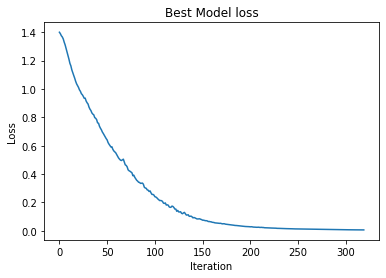

In [79]:
plt.plot(best_model.loss_curve_)
plt.title('Best Model loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('visualizations/best_model_loss.png')
plt.show()

In [36]:
print(f'Best loss: {round(best_model.best_loss_, 2)}')
print(f'Number of iterations: {best_model.n_iter_}')
print(f'Number of layers: {best_model.n_layers_}')
print(f'Output activation function: {best_model.out_activation_}')

Best loss: 0.01
Number of iterations: 320
Number of layers: 4
Output activation function: softmax
